In [1]:
import numpy as np
import h5py
import gudhi as gd
import gudhi.representations as gdr
import homcloud.interface as hc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.interpolate import interp1d
from Corrfunc.theory.xi import xi
from alpha_complex_periodic import calc_persistence
import illustris_python as tng
from gadgetutils import utils

In [2]:
plt.style.use("~/astro.mplstyle")

# Example alpha complex

Take galaxies in a 6 Mpc slice from the EX0 CAMELS IllustrisTNG sim

In [3]:
with h5py.File("../camels/IllustrisTNG/EX_0/fof_subhalo_tab_033.hdf5") as f:
    galaxies = f["Subhalo/SubhaloLenType"][:,4] > 10
    pos = f["Subhalo/SubhaloPos"][:][galaxies] / 1e3

In [4]:
np.random.seed(50)
pos_slice = utils.center_box_pbc(pos, 25*np.random.rand(3), 25)
cut = np.abs(pos_slice[:,2]) < 3
pos_slice = pos_slice[cut][:,:2] + 25/2
len(pos_slice)

303

tile points to approximate 2D periodic triangulation

In [5]:
from itertools import product

def tile_pos(pos, boxsize):
    d = pos.shape[1]
    tile = []
    for ind in product([-1,0,1], repeat=d):
        tile.append(pos + boxsize * np.array(ind))
    return np.vstack(tile)

In [6]:
pos_tiled = tile_pos(pos_slice, 25)

In [7]:
alpha = gd.AlphaComplex(points=pos_tiled)
st = alpha.create_simplex_tree()
st.compute_persistence()

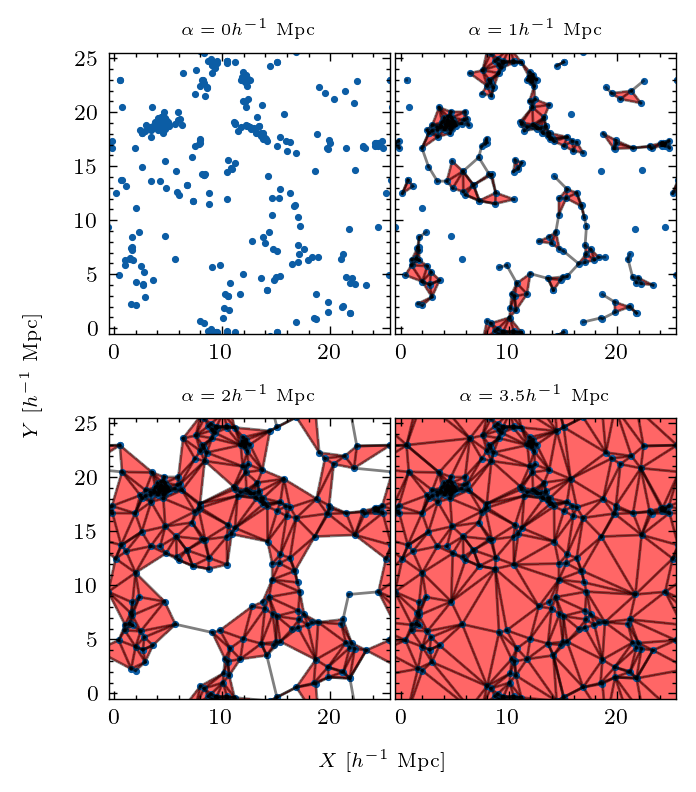

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(3.38,3.8), dpi=200, sharey="row")
for i, a in enumerate([0, 1, 2, 3.5]):
    ax = axs[i//2,i%2]
    segments = np.array([s[0] for s in st.get_skeleton(1) if len(s[0]) == 2 and s[1] <= a**2])
    triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= a**2])
    
    if len(triangles) > 0:
        triangulation = Triangulation(*pos_tiled.T, triangles)
        ax.tripcolor(triangulation, np.ones(len(triangles)), alpha=0.6, cmap=mpl.colors.ListedColormap("red"), rasterized=True)
    if len(segments) > 0:
        ax.plot(*pos_tiled[segments].T, color='k', alpha=0.5)

    ax.scatter(*pos_tiled.T, marker='.', s=10)
    
    ax.set_title(f"$\\alpha = {a} h^{{-1}}$ Mpc", fontsize=6)
    ax.set_xlim(-0.5,25.5)
    ax.set_ylim(-0.5,25.5)
    
    if i == 0:
        ticks = ax.get_yticks()
        labels = ax.get_yticklabels()
    ax.set_xticks(ticks[1:-1], labels[1:-1])

plt.subplots_adjust(bottom=0.1, left=0.14, right=0.98, top=0.95, wspace=0.02, hspace=0.3)
plt.figtext(0.009, 0.45, "$Y$ [$h^{-1}$ Mpc]", fontsize=7, rotation="vertical")
plt.figtext(0.45, 0.01, "$X$ [$h^{-1}$ Mpc]", fontsize=7)
plt.savefig("../figs/galaxies_alpha_small.pdf")
plt.show()

In [9]:
pairs = [np.sqrt(st.persistence_intervals_in_dimension(d)) for d in range(3)]

DS = gdr.preprocessing.DiagramSelector(use=True)
t = np.linspace(0, 4, 150)
BC = gdr.BettiCurve(predefined_grid=t)
bc = BC.fit_transform(DS.fit_transform(pairs))

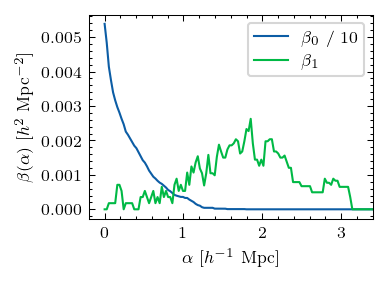

In [10]:
labels = ["$\\beta_0$ / 10", "$\\beta_1$"]

plt.figure(figsize=(0.8*3.38, 0.8*2.5), dpi=150)
for d in range(2):
    plt.plot(t, bc[d] / (1 if d else 10) / (9*9*25**2), label=labels[d])
plt.xlim(right=3.4)
plt.xlabel("$\\alpha$ [$h^{-1}$ Mpc]")
plt.ylabel("$\\beta(\\alpha)$ [$h^2$ Mpc$^{-2}$]")
plt.legend()
plt.subplots_adjust(bottom=0.2, left=0.2)
plt.savefig("../figs/galaxies_bc_periodic.pdf")
plt.show()

# Random points

In [12]:
with np.load("../topology_summaries/poisson/es_poisson_L25.npz") as data:
    alpha = data["alpha"]
    alpha_scaled = data["alpha_scaled"]
    lbar = data["lbar"]
    bc = data["bc"]
    bc_scaled = data["bc_scaled"]
    
with np.load("../topology_summaries/poisson/es_poisson_L75.npz") as data:
    mean_75 = np.mean(data["bc_scaled"], axis=0)

In [12]:
lbar_norm = plt.Normalize(np.min(lbar), np.max(lbar))
lbar_sm = plt.cm.ScalarMappable(lbar_norm, plt.cm.viridis)

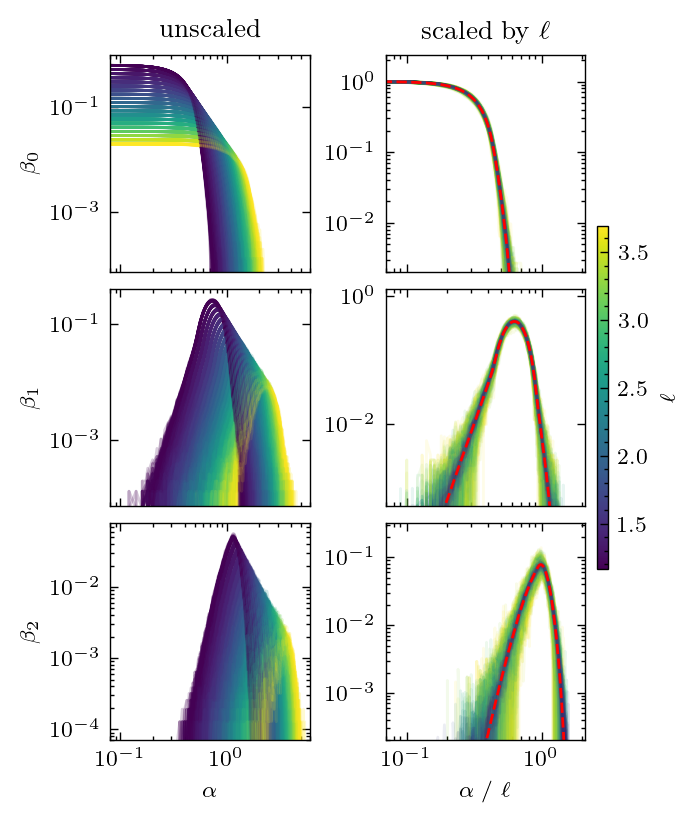

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(3.38, 4), dpi=200, sharex="col", constrained_layout=True)
for d in range(3):
    ax = axs[d,0]
    for i in range(len(bc)):
        color = plt.cm.viridis(lbar_norm(lbar[i]))
        ax.plot(alpha, bc[i,d], color=color, alpha=0.2, rasterized=True)
    ax.loglog()
    ax.set_xlim(0.08, 6)
    ax.set_ylim(bottom=7e-5)
    ax.set_ylabel(f"$\\beta_{d}$")

ylims = [2e-3, 5e-4, 2e-4]
for d in range(3):
    ax = axs[d,1]
    for i in range(len(bc)):
        color = plt.cm.viridis(lbar_norm(lbar[i]))
        ax.plot(alpha_scaled, bc_scaled[i,d], color=color, alpha=0.1, rasterized=True)
    ax.plot(alpha_scaled, mean_75[d], 'r--')
    ax.loglog()
    ax.set_xlim(0.07, 2.1)
    ax.set_ylim(bottom=ylims[d])
    #ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")

axs[0,0].set_title("unscaled")
axs[0,1].set_title("scaled by $\ell$")
axs[2,0].set_xlabel("$\\alpha$")    
axs[2,1].set_xlabel("$\\alpha$ / $\ell$")
    
plt.colorbar(lbar_sm, ax=axs, shrink=0.5, aspect=30, pad=0.025, label="$\ell$")
plt.savefig("../figs/poisson_betti_vert.pdf")
plt.show()

In [11]:
with np.load("../lognormal_reject_sampling_1.5.npz", allow_pickle=True) as f:
    samples_ln = f["data"]
    r0_ln = f["r0"]
    gamma_ln = f["gamma"]
    lbar_ln = f["lbar"]

with np.load("../topology_summaries/lognormal/es_lognormal_reject_sampling_1.5.npz") as f:
    bc_ln = f["bc_scaled"]

In [13]:
mask = r0_ln < 6
np.sum(mask)

297

In [14]:
r0_bins = np.linspace(np.min(r0_ln[mask]), np.max(r0_ln[mask]), 11)
bin_inds = np.digitize(r0_ln[mask], r0_bins)
avg_bc = []
avg_r0 = []
for i in range(1, len(r0_bins)):
    selection = bin_inds == i
    print(np.sum(selection))
    avg_bc.append(np.mean(bc_ln[mask][selection], axis=0))
    avg_r0.append(np.mean(r0_ln[mask][selection]))

21
38
29
42
36
28
32
28
21
21


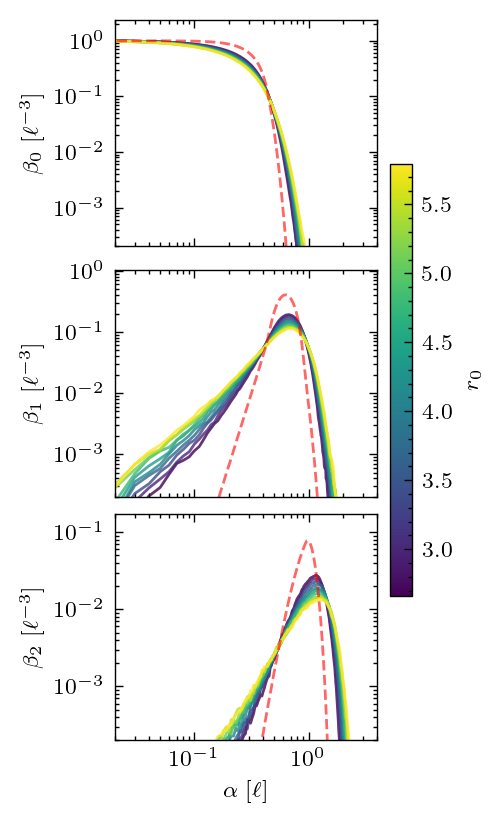

In [15]:
ylims = [[5e-3, 1.3], [5e-4, 0.3], [2e-4, 4e-2]]

norm = plt.Normalize(vmin=np.min(avg_r0), vmax=np.max(avg_r0))
sm = plt.cm.ScalarMappable(norm, plt.cm.viridis)

fig, axs = plt.subplots(3, 1, figsize=(2.4,4), dpi=200, sharex=True, constrained_layout=True)
for d in range(3):
    ax = axs[d]
    for i in range(len(avg_bc)):
        color = plt.cm.viridis(norm(avg_r0[i]))
        ax.plot(alpha_scaled, avg_bc[i][d,:], color=color, alpha=0.8)
    ax.plot(alpha_scaled, mean_75[d], 'r--', alpha=0.6)
    ax.loglog()
    ax.set_ylim(bottom=2e-4)
    ax.set_xlim(2e-2, 4)
    ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")
    
axs[2].set_xlabel("$\\alpha$ [$\ell$]")
plt.colorbar(sm, ax=axs, shrink=0.6, label="$r_0$")
plt.savefig("../figs/lognormal_betti_vert.pdf")
plt.show()

# DM halos

In [41]:
path = "../TNG300"
snap_num = 99

In [42]:
header = tng.groupcat.loadHeader(path, snap_num)
boxsize = header["BoxSize"] / 1e3
n_subs = header["Nsubgroups_Total"]
print(path, f"box = {boxsize} Mpc, {n_subs:.3e} subhalos total")

../TNG300 box = 205.0 Mpc, 1.449e+07 subhalos total


In [43]:
DS = gdr.preprocessing.DiagramSelector(use=True)
BC = gdr.BettiCurve(resolution=2000, sample_range=[0, boxsize/3])
alpha = np.linspace(*BC.sample_range, BC.resolution)
alpha_scaled = np.linspace(0, 5, 500)

In [44]:
fields = ["GroupPos", "Group_M_Crit200"]
tng_data = tng.groupcat.loadHalos(path, snap_num, fields=fields)

In [45]:
pos = tng_data["GroupPos"] / 1e3
mass = tng_data["Group_M_Crit200"] * 1e10
mass_cut = 3.2e10
halos = mass > mass_cut
print(np.sum(halos), "halos total")

536660 halos total


In [46]:
log_mass = np.log10(mass[halos])
mass_bins = [11, 11.5, 12]
bin_inds = np.digitize(log_mass, mass_bins)

halo_samples = []
for i in range(len(mass_bins)+1):
    mask = bin_inds == i
    halo_samples.append(pos[halos][mask])

N_sample = np.array([len(p) for p in halo_samples])
lbar_sample = boxsize / np.cbrt(N_sample)

print(N_sample)

[323911 133834  52542  26373]


In [47]:
labels = ["(10.5, 11]", "(11, 11.5]", "(11.5, 12]", "  $>$ 12", ""]
colors = ['blue', 'orange', 'green', 'red', "darkviolet"]

[Warning] The CPU supports AVX512F but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?


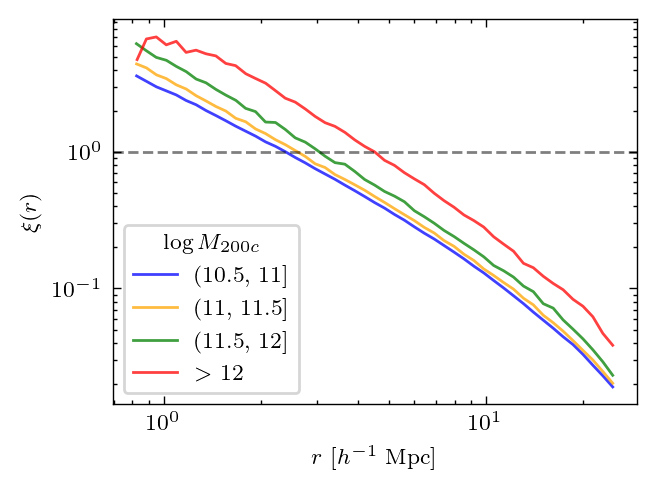

In [49]:
rbins = np.logspace(-0.1, np.log10(boxsize/8), 50)
xi_halos = [xi(boxsize, 2, rbins, *points.T, output_ravg=True) for points in halo_samples]


fits = [stats.linregress(np.log(x["ravg"][x["xi"]>0][i:-5]), np.log(x["xi"][x["xi"]>0][i:-5])) for i, x in enumerate(xi_halos)]
x_fit = np.logspace(0, 1.3, 10)

plt.figure(figsize=(3.38, 2.5), dpi=200)
for i, x in enumerate(xi_halos):
    plt.plot(x["ravg"], x["xi"], '-', color=colors[i], alpha=0.75, label=labels[i])

plt.loglog()
plt.axhline(1, ls='--', color='k', alpha=0.5)
plt.xlabel("$r$ [$h^{-1}$ Mpc]")
plt.ylabel("$\\xi(r)$")
plt.legend(frameon=True, fontsize=8, title="$\\log M_{200c}$")
#plt.savefig("../figs/halos_xi.pdf")
plt.show()

In [50]:
gamma = np.array([[fit.slope, fit.stderr] for fit in fits])
r0 = np.array([np.exp(-fit.intercept/fit.slope) for fit in fits])

print("Halo sample\t lbar [Mpc]\t r0 [Mpc]\t gamma")
for i in range(4):
    print(f"  {labels[i]}\t {lbar_sample[i]:.2f}\t\t {r0[i]:.2f}\t\t {gamma[i,0]:.2f}+/-{gamma[i,1]:.2f}")

Halo sample	 lbar [Mpc]	 r0 [Mpc]	 gamma
  (10.5, 11]	 2.99		 2.29		 -1.41+/-0.02
  (11, 11.5]	 4.01		 2.53		 -1.45+/-0.01
  (11.5, 12]	 5.47		 3.00		 -1.50+/-0.01
    $>$ 12	 6.89		 4.21		 -1.52+/-0.02


In [51]:
pairs = [calc_persistence(points, boxsize=boxsize, precision="fast") for points in halo_samples]
pairs = [[np.array(p[d]) for d in range(3)] for p in pairs]

In [52]:
bc = np.array([BC.fit_transform(DS.fit_transform(p)) for p in pairs]) / boxsize**3
bc.shape

(4, 3, 2000)

In [53]:
bc_scaled = np.zeros((len(bc), 3, len(alpha_scaled)))

for i in range(4):
    interp = interp1d(alpha/lbar_sample[i], bc[i], axis=-1, bounds_error=False, fill_value=0, assume_sorted=True)
    bc_scaled[i] = interp(alpha_scaled) * lbar_sample[i]**3

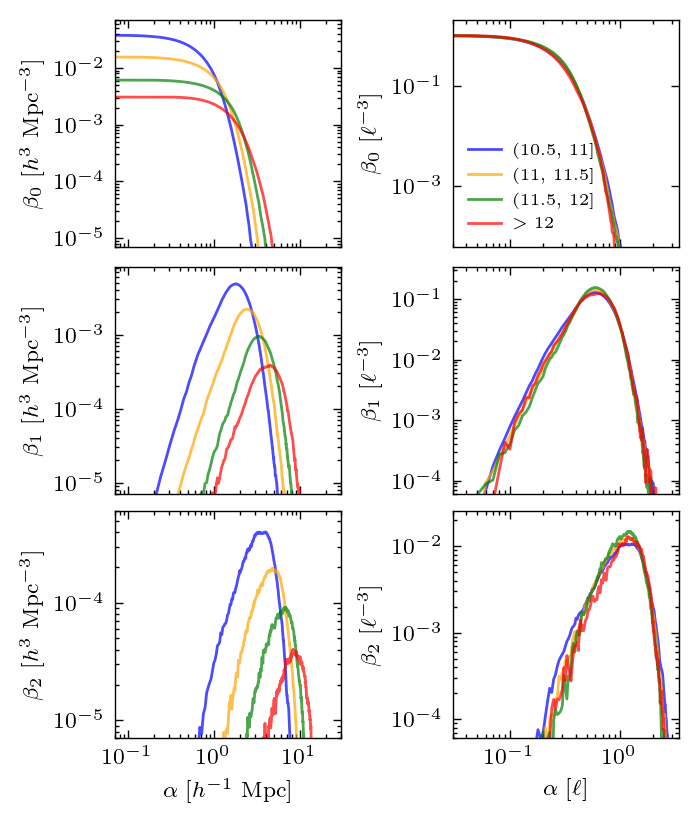

In [64]:
xlims = [4, 10, 20]
fig, axs = plt.subplots(3, 2, figsize=(3.38, 4), sharex="col", constrained_layout=True, dpi=200)
for d in range(3):
    ax = axs[d,0]
    for i in range(len(bc)):
        ax.plot(alpha, bc[i,d], color=colors[i], alpha=0.7, label=labels[i])
    ax.loglog()
    ax.set_xlim(7e-2, 30)
    ax.set_ylim(bottom=7e-6)
    ax.set_ylabel(f"$\\beta_{d}$ [$h^3$ Mpc$^{{-3}}$]")
    #if not d: ax.legend(frameon=True, title="$\log M_{200c}$", fontsize=6)
    
for d in range(3):
    ax = axs[d,1]
    for i in range(len(bc)):
        ax.plot(alpha_scaled, bc_scaled[i,d], color=colors[i], label=labels[i], alpha=0.7)
    #plt.plot(alpha_scaled, poisson_mean[d], 'k--', alpha=0.5, label="Poisson")
    #plt.plot(alpha_scaled, ln_mean[d], 'k-.', alpha=0.5, label="Log-normal")
    ax.loglog()
    ax.set_xlim(3e-2, 3.5)
    ax.set_ylim(bottom=6e-5)
    ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")
    if not d: ax.legend(frameon=False, fontsize=6)
    
axs[2,0].set_xlabel("$\\alpha$ [$h^{-1}$ Mpc]")
axs[2,1].set_xlabel("$\\alpha$ [$\ell$]")

plt.savefig("../figs/halos_betti_vert.pdf")
plt.show()

# Galaxies

In [3]:
def mean_conf_int(data, p=0.68):
    mean = np.mean(data, axis=0)
    lq = np.quantile(data, 0.5 - p/2, axis=0)
    hq = np.quantile(data, 0.5 + p/2, axis=0)
    return mean, lq, hq

In [8]:
# CAMELS-SAM Fiducial model - CV set
#with np.load("../topology_summaries/camels-sam/es_CV_all_rhalos_q10p5.npz") as data:
with np.load("../topology_summaries/camels-sam/es_CV_all_mstar5e8_rhalos_q10p5.npz") as data:
    alpha_sam = data["alpha"]
    alpha_scaled = data["alpha_scaled"]
    bc_cv_sam = data["bc"]
    bc_scaled_cv_sam = data["bc_scaled"]
    xi_cv_sam = data["xi"]
    xi_ravg_cv_sam = data["xi_ravg"]
    
# CAMELS-SAM LH set
#with np.load("../topology_summaries/camels-sam/es_LH_all_rhalos_q10p5.npz") as data:
with np.load("../topology_summaries/camels-sam/es_LH_all_mstar5e8_rhalos_q10p5.npz") as data:
    params_lh_sam = data["params"]
    bc_lh_sam = data["bc"]
    bc_scaled_lh_sam = data["bc_scaled"]
    
# CAMELS-SAM 1P set
#with np.load("../topology_summaries/camels-sam/es_1P_all_rhalos_q10p5.npz") as data:
with np.load("../topology_summaries/camels-sam/es_1P_all_mstar5e8_rhalos_q10p5.npz") as data:
#with np.load("../topology_summaries/camels-sam/es_1P_all.npz") as data:
    params_1p_sam = data["params"]
    bc_1p_sam = data["bc"]
    bc_scaled_1p_sam = data["bc_scaled"]
    
# TNG300 
#with np.load("../topology_summaries/TNG300/es_all2.npz") as data:
#with np.load("../topology_summaries/TNG300/es_all_rhalos_q10p5.npz") as data:
with np.load("../topology_summaries/TNG300/es_all_mstar5e8_rhalos_q10p5.npz") as data:
    alpha_tng300 = data["alpha"]
    bc_tng300 = data["bc"]
    bc_scaled_tng300 = data["bc_scaled"]
    xi_ravg_tng300 = data["xi_ravg"]
    xi_tng300 = data["xi"]

In [5]:
param_names = ["$\\Omega_m$", "$\\sigma_8$", "$A_{SN1}$", "$A_{AGN1}$", "$A_{SN2}$", "$A_{AGN2}$"]
param_names_sam = ["$\\Omega_m$", "$\\sigma_8$", "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN}$"]
selections = ["halos", "galaxies", "star-forming galaxies", "quiescent galaxies"]

In [6]:
params_fid = np.array([0.3, 0.8, 1, 1, 1, 1])
params_range = np.array([[0.1, 0.5],
               [0.6, 1],
               [0.25, 4],
               [0.25, 4],
               [0.5, 2],
               [0.5, 2]])

params_fid_sam = np.array([0.3, 0.8, 1, 0, 1])
params_range_sam = np.array([[0.1, 0.5],
                   [0.6, 1],
                   [0.25, 4],
                   [-2, 2],
                   [0.25, 4]])

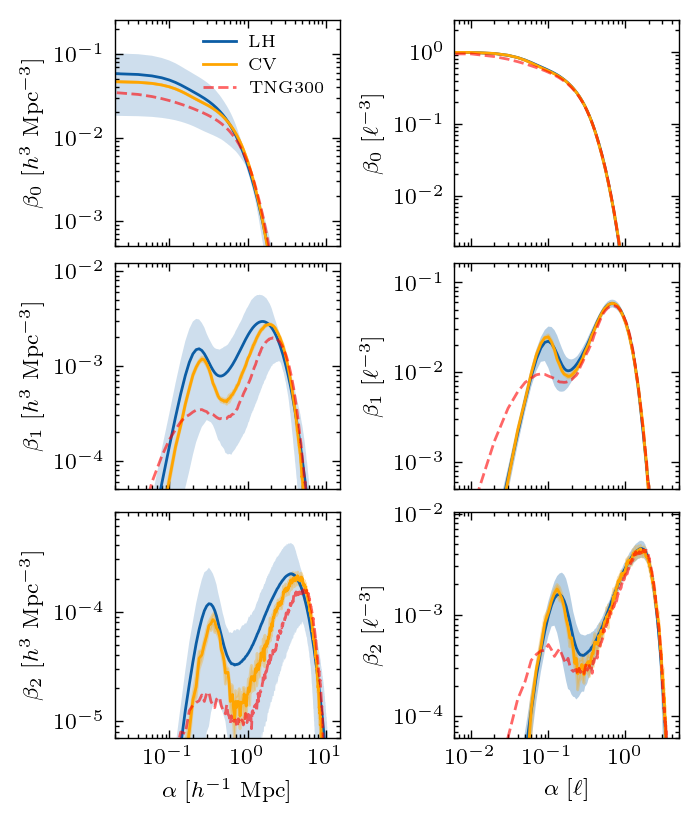

In [9]:
ylims1 = [5e-4, 5e-5, 7e-6]
ylims2 = [2e-3, 5e-4, 6e-5]

fig, axs = plt.subplots(3, 2, figsize=(3.38,4), sharex="col", constrained_layout=True, dpi=200)
for d in range(3):
    mean_cv, lq_cv, hq_cv = mean_conf_int(bc_cv_sam[:,1,d,:], p=0.68)
    mean_lh, lq_lh, hq_lh = mean_conf_int(bc_lh_sam[:,1,d,:], p=0.68)
    
    ax = axs[d,0]
    ax.plot(alpha_sam, mean_lh, label="LH")
    ax.fill_between(alpha_sam, lq_lh, hq_lh, alpha=0.2)
    ax.plot(alpha_sam, mean_cv, color='orange', label="CV")
    ax.fill_between(alpha_sam, lq_cv, hq_cv, alpha=0.3, color='orange')
    ax.plot(alpha_tng300, bc_tng300[0,1,d,:], 'r--', alpha=0.6, label="TNG300")
    ax.loglog()
    ax.set_xlim(2e-2, 15)
    ax.set_ylim(bottom=ylims1[d])
    if not d: ax.legend(fontsize=6, frameon=False)
    ax.set_ylabel(f"$\\beta_{d}$ [$h^3$ Mpc$^{{-3}}$]")
    
    mean_cv, lq_cv, hq_cv = mean_conf_int(bc_scaled_cv_sam[:,1,d,:], p=0.68)
    mean_lh, lq_lh, hq_lh = mean_conf_int(bc_scaled_lh_sam[:,1,d,:], p=0.68)
    
    ax = axs[d,1]
    ax.plot(alpha_scaled, mean_lh)
    ax.fill_between(alpha_scaled, lq_lh, hq_lh, alpha=0.3)
    ax.plot(alpha_scaled, mean_cv, color='orange')
    ax.fill_between(alpha_scaled, lq_cv, hq_cv, alpha=0.3, color='orange')
    ax.plot(alpha_scaled, bc_scaled_tng300[0,1,d,:], 'r--', alpha=0.6)
    ax.loglog()
    ax.set_xlim(6e-3, 5)
    ax.set_ylim(bottom=ylims2[d])
    ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")
    
axs[2,0].set_xlabel("$\\alpha$ [$h^{-1}$ Mpc]")
axs[2,1].set_xlabel("$\\alpha$ [$\ell$]")

#plt.savefig("../figs/galaxies_betti_full_vert.pdf")
plt.show()

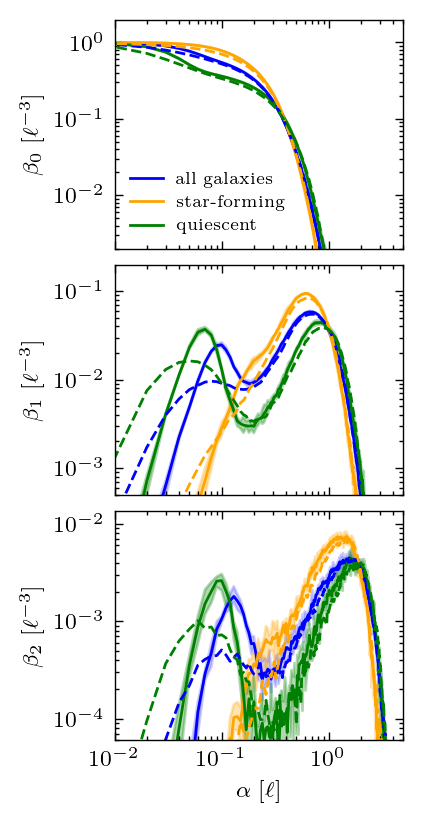

In [10]:
xlims = [1, 2.5, 4.5]
ylims = [2e-3, 5e-4, 6e-5]

fig, axs = plt.subplots(3, 1, figsize=(2,4), sharex=True, constrained_layout=True, dpi=200)
for d in range(3):
    ax = axs[d]
    mean_gal, lq_gal, hq_gal = mean_conf_int(bc_scaled_cv_sam[:,1,d,:], p=0.95)
    mean_sf, lq_sf, hq_sf = mean_conf_int(bc_scaled_cv_sam[:,2,d,:], p=0.95)
    mean_qsnt, lq_qsnt, hq_qsnt = mean_conf_int(bc_scaled_cv_sam[:,3,d,:], p=0.95)
    
    mean_gal_tng300, lq_gal_tng300, hq_gal_tng300 = mean_conf_int(bc_scaled_tng300[:,1,d,:], p=0.95)
    mean_sf_tng300, lq_sf_tng300, hq_sf_tng300 = mean_conf_int(bc_scaled_tng300[:,2,d,:], p=0.95)
    mean_qsnt_tng300, lq_qsnt_tng300, hq_qsnt_tng300 = mean_conf_int(bc_scaled_tng300[:,3,d,:], p=0.95)

    ax.plot(alpha_scaled, mean_gal, color='blue', label="all galaxies" if not d else "CAMELS-SAM")
    ax.fill_between(alpha_scaled, lq_gal, hq_gal, color='blue', alpha=0.2)
    ax.plot(alpha_scaled, mean_sf, color='orange', label="star-forming" if not d else "")
    ax.fill_between(alpha_scaled, lq_sf, hq_sf, alpha=0.3, color='orange')
    ax.plot(alpha_scaled, mean_qsnt, color='green', label="quiescent" if not d else "")
    ax.fill_between(alpha_scaled, lq_qsnt, hq_qsnt, color='green', alpha=0.3)
    
    ax.plot(alpha_scaled, mean_gal_tng300, '--', color='blue', label="TNG300" if d else "")
    ax.plot(alpha_scaled, mean_sf_tng300, '--', color='orange')
    ax.plot(alpha_scaled, mean_qsnt_tng300, '--', color='green')

    ax.loglog()
    ax.set_xlim(1e-2, 5)
    #ticks = [0.01, 0.1, 1, 2, 4]
    #plt.xticks(ticks, ticks)
    ax.set_ylim(bottom=ylims[d])
    if not d: ax.legend(fontsize=6, frameon=False)
    #if d == 1: plt.legend(fontsize=6, frameon=False)

    ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")
axs[2].set_xlabel("$\\alpha$ [$\\ell$]")
    
#plt.savefig("../figs/galaxies_betti_vert.pdf")
plt.show()

In [11]:
alpha_scaled_log = np.logspace(-2.1, np.log10(4), 100)
interp = interp1d(alpha_scaled, bc_scaled_cv_sam, axis=-1, assume_sorted=True)
bc_scaled_cv_sam_log = interp(alpha_scaled_log)
interp = interp1d(alpha_scaled, bc_scaled_1p_sam, axis=-1, assume_sorted=True)
bc_scaled_1p_sam_log = interp(alpha_scaled_log)

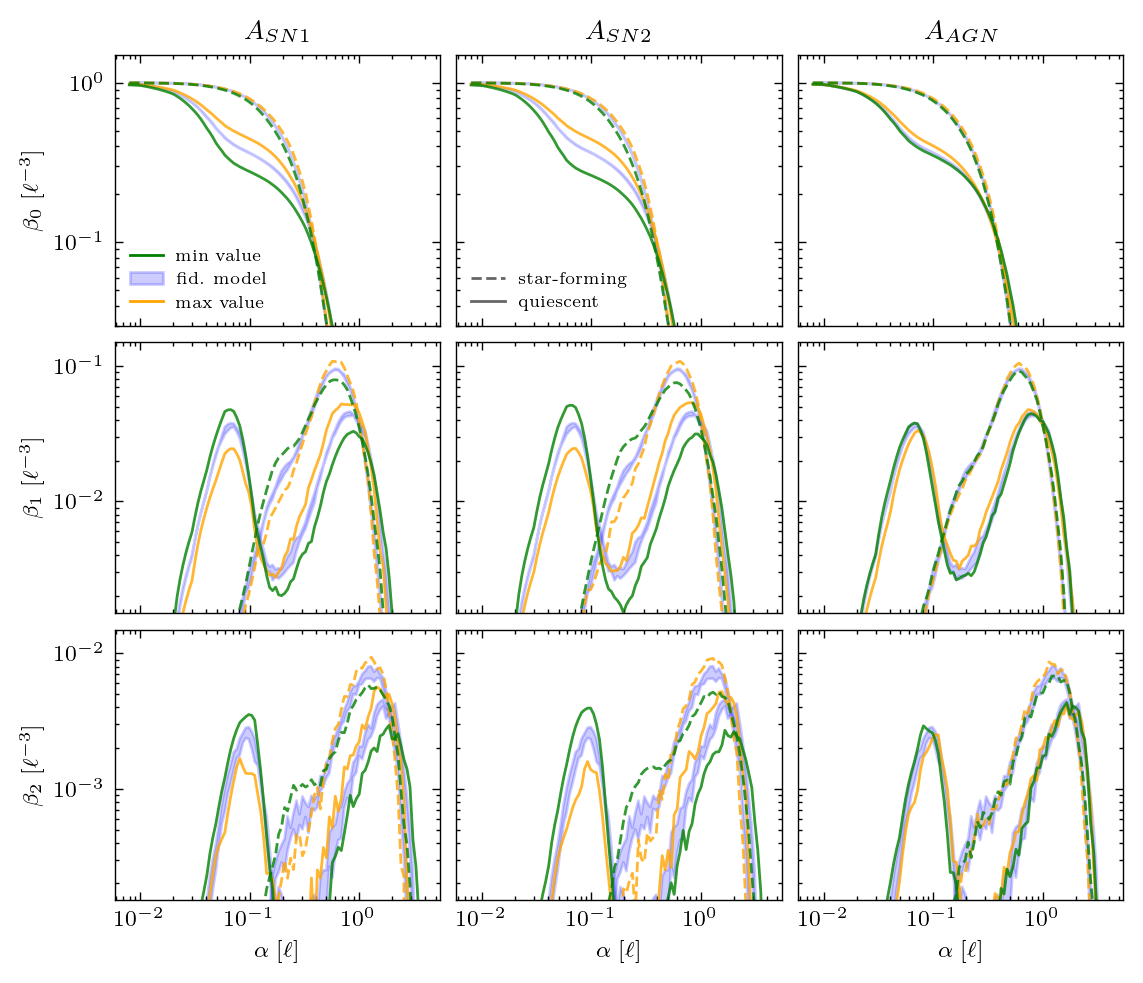

In [12]:
xlims = [1, 2.5, 4.5]
ylims = [[3e-2, 1.5], [1.5e-3, 0.15], [1.5e-4, 1.5e-2]]

fig, axs = plt.subplots(3, 3, figsize=(0.8*7,0.8*6), sharey="row", sharex="col", constrained_layout=True, dpi=200)
for d in range(3):
    
    mean_fid_sf, lq_fid_sf, hq_fid_sf = mean_conf_int(bc_scaled_cv_sam_log[:,2,d,:], p=0.68)
    mean_fid_qsnt, lq_fid_qsnt, hq_fid_qsnt = mean_conf_int(bc_scaled_cv_sam_log[:,3,d,:], p=0.68)
        
    for p in range(3):
        param_i = p + 2
        ax = axs[d,p]
        
        mask_min = params_1p_sam[:,param_i] == params_range_sam[param_i,0]
        mean_min_sf, lq_min_sf, hq_min_sf = mean_conf_int(bc_scaled_1p_sam_log[mask_min][:,2,d,:], p=0.95)
        mean_min_qsnt, lq_min_qsnt, hq_min_qsnt = mean_conf_int(bc_scaled_1p_sam_log[mask_min][:,3,d,:], p=0.95)
        mask_max = params_1p_sam[:,param_i] == params_range_sam[param_i,1]
        mean_max_sf, lq_max_sf, hq_max_sf = mean_conf_int(bc_scaled_1p_sam_log[mask_max][:,2,d,:], p=0.95)
        mean_max_qsnt, lq_max_qsnt, hq_max_qsnt = mean_conf_int(bc_scaled_1p_sam_log[mask_max][:,3,d,:], p=0.95)
        
        #ax.plot(alpha_scaled, mean_fid_sf, color='blue', ls='-')
        ax.fill_between(alpha_scaled_log, lq_fid_sf, hq_fid_sf, color='blue', alpha=0.2)
        #ax.plot(alpha_scaled, mean_fid_qsnt, color='blue', ls='--')
        ax.fill_between(alpha_scaled_log, lq_fid_qsnt, hq_fid_qsnt, color='blue', alpha=0.2)
        
        ax.plot(alpha_scaled_log, mean_max_sf, '--', color='orange', alpha=0.8)
        ax.plot(alpha_scaled_log, mean_max_qsnt, '-', color='orange', alpha=0.8)
        #ax.fill_between(alpha_scaled, lq_max, hq_max, alpha=0.3, color='orange')
        ax.plot(alpha_scaled_log, mean_min_sf, '--', color='green', alpha=0.8)
        ax.plot(alpha_scaled_log, mean_min_qsnt, '-', color='green', alpha=0.8)
        #ax.fill_between(alpha_scaled, lq_min, hq_min, color='green', alpha=0.3)
        ax.loglog()
        ax.set_ylim(*ylims[d])
        
        if not d: ax.set_title(param_names_sam[param_i])

        if not p: ax.set_ylabel(f"$\\beta_{d}$ [$\ell^{{-3}}$]")
        if d == 2: ax.set_xlabel("$\\alpha$ [$\\ell$]")
        
        if not d and p == 0: 
            ax.plot([], [], color='green', label="min value")
            ax.fill_between([], [], color='blue', alpha=0.2, label="fid. model")
            ax.plot([], [], color="orange", label="max value")
            ax.legend(fontsize=6, frameon=False)
            
        if not d and p == 1:
            ax.plot([], [], 'k--', alpha=0.6, label="star-forming")
            ax.plot([], [], 'k-', alpha=0.6, label="quiescent")
            ax.legend(fontsize=6, frameon=False)

#plt.savefig("../figs/sf_qsnt_1p.pdf")
plt.show()